In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from spacy.lang.en import English

In [2]:
complaints = pd.read_csv('complaints.csv')

In [3]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353432 entries, 0 to 353431
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  353432 non-null  object
 1   Issue                         353432 non-null  object
dtypes: object(2)
memory usage: 5.4+ MB


In [4]:
complaints[['Consumer complaint narrative', 'Issue']] = complaints[['Consumer complaint narrative', 'Issue']].astype('str')

In [5]:
complaints.groupby('Issue').count().sort_values('Consumer complaint narrative', ascending = False)

,Consumer complaint narrative
Issue,
Incorrect information on your report,229305
Attempts to collect debt not owed,73163
Communication tactics,21243
Struggling to pay mortgage,17374
Fraud or scam,12347


In [6]:
# Define a regular expression pattern to match capitalized words
pattern = r'\b[A-Z][a-z]*\b'

# Define a function to count the number of capitalized words in a string
def count_capitalized_words(string):
    return len(re.findall(pattern, string))

# Apply the function to the 'strings' column
complaints['num_capitalized_words'] = complaints['Consumer complaint narrative'].apply(count_capitalized_words)

# Output the result
print(complaints['num_capitalized_words'])

0          14
1          36
2           5
3          96
4           5
         ... 
353427      2
353428     83
353429     73
353430    125
353431      1
Name: num_capitalized_words, Length: 353432, dtype: int64


In [7]:
Capital_Counts_by_Issue = pd.DataFrame(complaints.groupby('Issue')['num_capitalized_words'].sum())

In [9]:
complaints.head()

,Consumer complaint narrative,Issue,num_capitalized_words
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report,14
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam,36
2,I have a particular account that is stating th...,Incorrect information on your report,5
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed,96
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report,5


In [22]:
nlp = English()

count = 0

for complaint in complaints['Consumer complaint narrative']:
    doc = nlp(complaint)
    for token in doc:
        if token.is_alpha and token.is_title:
            count += 1

print(count)

6208654


In [24]:
counts_by_issue = {}

for issue in complaints['Issue'].unique():
    issue_df = complaints[complaints['Issue'] == issue]
    count = 0
    for complaint in issue_df['Consumer complaint narrative']:
        doc = nlp(complaint)
        for token in doc:
            if token.is_alpha and token.is_title:
                count += 1
    counts_by_issue[issue] = count

print(counts_by_issue)

{'Incorrect information on your report': 3770465, 'Fraud or scam': 295333, 'Attempts to collect debt not owed': 1289670, 'Communication tactics': 280825, 'Struggling to pay mortgage': 572361}


In [25]:
counts_by_issue

{'Incorrect information on your report': 3770465,
 'Fraud or scam': 295333,
 'Attempts to collect debt not owed': 1289670,
 'Communication tactics': 280825,
 'Struggling to pay mortgage': 572361}

In [27]:
cols = ['Consumer complaint narrative', 'Issue']
complaints = complaints[cols]

In [29]:
complaints['category_id'] = complaints['Issue'].factorize()[0]
category_id_complaints = complaints[['Issue', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_complaints.values)
id_to_category = dict(category_id_complaints[['category_id', 'Issue']].values)
complaints.head()

,Consumer complaint narrative,Issue,category_id
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report,0
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam,1
2,I have a particular account that is stating th...,Incorrect information on your report,0
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed,2
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report,0


In [32]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353432 entries, 0 to 353431
Data columns (total 3 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  353432 non-null  object
 1   Issue                         353432 non-null  object
 2   category_id                   353432 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.1+ MB


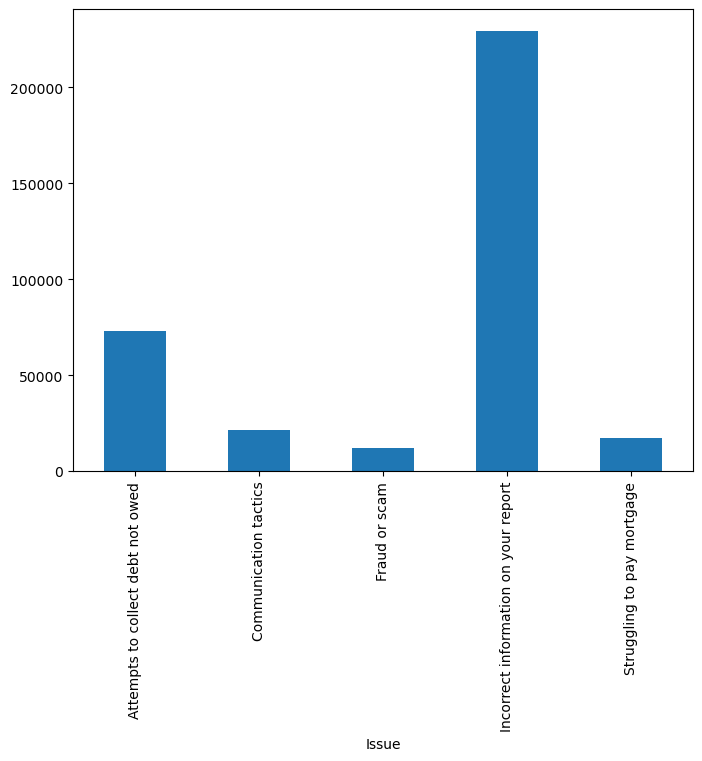

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
complaints.groupby('Issue')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1000, ngram_range=(2,2), stop_words='english')
features = tfidf.fit_transform(complaints['Consumer complaint narrative']).toarray()
labels = complaints.category_id
features.shape

MemoryError: Unable to allocate 192. MiB for an array with shape (25229111,) and data type int64

In [42]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Issue, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Issue))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Attempts to collect debt not owed':
  . Most correlated bigrams:
. collection agency
. collect debt
# 'Communication tactics':
  . Most correlated bigrams:
. stop calling
. times day
# 'Fraud or scam':
  . Most correlated bigrams:
. send money
. sent money
# 'Incorrect information on your report':
  . Most correlated bigrams:
. times day
. collect debt
# 'Struggling to pay mortgage':
  . Most correlated bigrams:
. short sale
. loan modification


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(complaints['Consumer complaint narrative'], complaints['Issue'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# Define a function to tokenize a string
def tokenize_string(string):
    return nltk.word_tokenize(string)

# Apply the function to the 'strings' column
complaints['complaint_tokens'] = complaints['Consumer complaint narrative'].apply(tokenize_string)

# Output the result
print(complaints['complaint_tokens'])